## <center> <u> GRU Adri - With and Without Exogenous Variables

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [3]:
query="""
    select * 
    from agg.tidy_data
    where site = 64
"""

In [16]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


## <u> Without Exogenous Variables

<Axes: >

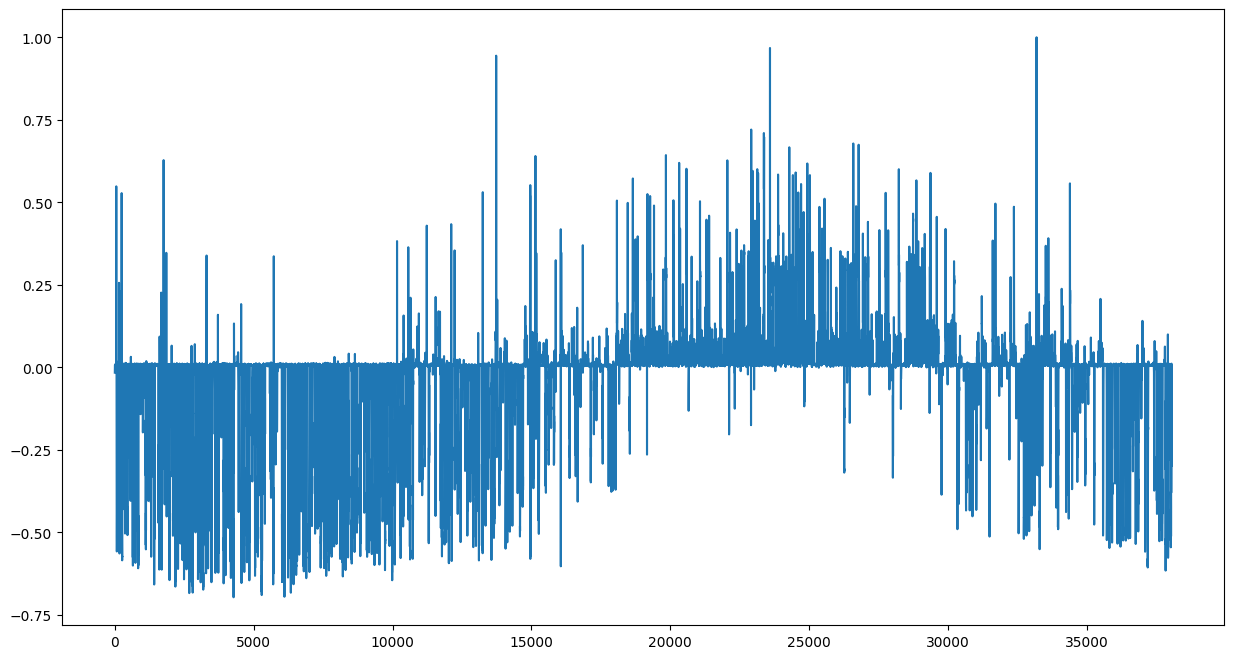

In [17]:
df = df[['net_load']]

df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

plt.figure(figsize=(15,8))
df['net_load_norm'].plot()

In [18]:
#Create lags - The previous week is used
num_lags = 7 * 24 * 4  # Number of lags
for i in range(1, num_lags + 1):
    df[f'lag_{i}'] = df['net_load_norm'].shift(i)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/69662595.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{i}'] = df['net_load_norm'].shift(i)
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/69662595.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{i}'] = df['net_load_norm'].shift(i)
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/69662595.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [19]:
train_data = df.iloc[:-2*96]
val_data = df.iloc[-2*96:-96]
test_data = df.iloc[-96:]

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [12]:
devices= tf.config.list_physical_devices()

print("Devices: ",devices)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [79]:
gru_model = keras.Sequential()
gru_model.add(GRU(64, input_shape=(num_lags, 1)))
gru_model.add(layers.BatchNormalization())
gru_model.add(layers.Dense(1))
print(gru_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,185
Trainable params: 13,057
Non-trainable params: 128
_________________________________________________________________
None


2024-03-26 20:17:56.310448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:17:56.310981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:17:56.311724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)

# Prepare input data and target variable for training
X_train = train_data.drop(['net_load_norm'], axis=1).values.reshape(-1, num_lags, 1)
y_train = train_data['net_load_norm'].values

X_val = val_data.drop(['net_load_norm'], axis=1).values.reshape(-1, num_lags, 1)
y_val = val_data['net_load_norm'].values

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/308478683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_19547/308478683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.dropna(inplace=True)


In [115]:
train_data

,net_load_norm,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_663,lag_664,lag_665,lag_666,lag_667,lag_668,lag_669,lag_670,lag_671,lag_672
672,0.007195,0.007511,0.007491,0.007235,0.007027,0.006879,0.007235,0.007856,0.006741,0.006208,...,0.007363,0.006623,0.007313,0.008439,0.007313,0.007235,0.009287,0.007304,0.007077,0.007422
673,0.006850,0.007195,0.007511,0.007491,0.007235,0.007027,0.006879,0.007235,0.007856,0.006741,...,0.007432,0.007363,0.006623,0.007313,0.008439,0.007313,0.007235,0.009287,0.007304,0.007077
674,0.007195,0.006850,0.007195,0.007511,0.007491,0.007235,0.007027,0.006879,0.007235,0.007856,...,0.007353,0.007432,0.007363,0.006623,0.007313,0.008439,0.007313,0.007235,0.009287,0.007304
675,0.007383,0.007195,0.006850,0.007195,0.007511,0.007491,0.007235,0.007027,0.006879,0.007235,...,0.007817,0.007353,0.007432,0.007363,0.006623,0.007313,0.008439,0.007313,0.007235,0.009287
676,0.007402,0.007383,0.007195,0.006850,0.007195,0.007511,0.007491,0.007235,0.007027,0.006879,...,0.007284,0.007817,0.007353,0.007432,0.007363,0.006623,0.007313,0.008439,0.007313,0.007235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37857,0.007402,0.008360,0.007373,0.006909,0.007215,0.007540,0.006968,0.006840,0.006682,0.007195,...,0.006583,0.006790,0.006672,-0.002754,0.004254,0.012781,-0.000474,-0.068812,-0.149497,-0.165495
37858,0.007738,0.007402,0.008360,0.007373,0.006909,0.007215,0.007540,0.006968,0.006840,0.006682,...,0.008231,0.006583,0.006790,0.006672,-0.002754,0.004254,0.012781,-0.000474,-0.068812,-0.149497
37859,0.007284,0.007738,0.007402,0.008360,0.007373,0.006909,0.007215,0.007540,0.006968,0.006840,...,0.007106,0.008231,0.006583,0.006790,0.006672,-0.002754,0.004254,0.012781,-0.000474,-0.068812
37860,0.007422,0.007284,0.007738,0.007402,0.008360,0.007373,0.006909,0.007215,0.007540,0.006968,...,0.007215,0.007106,0.008231,0.006583,0.006790,0.006672,-0.002754,0.004254,0.012781,-0.000474


In [81]:
gru_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])
gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10


2024-03-26 20:18:11.592620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:18:11.593211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:18:11.593935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 137s 117ms/step - loss: 0.0635 - mean_absolute_error: 0.0635 - val_loss: 0.0823 - val_mean_absolute_error: 0.0823
Epoch 2/10


2024-03-26 20:20:28.086244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:20:28.087117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:20:28.087744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 134s 115ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0830 - val_mean_absolute_error: 0.0830
Epoch 3/10
1163/1163 [==============================] - 133s 115ms/step - loss: 0.0596 - mean_absolute_error: 0.0596 - val_loss: 0.0862 - val_mean_absolute_error: 0.0862
Epoch 4/10
1163/1163 [==============================] - 133s 114ms/step - loss: 0.0596 - mean_absolute_error: 0.0596 - val_loss: 0.0828 - val_mean_absolute_error: 0.0828
Epoch 5/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0810 - val_mean_absolute_error: 0.0810
Epoch 6/10
1163/1163 [==============================] - 133s 114ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0884 - val_mean_absolute_error: 0.0884
Epoch 7/10
1163/1163 [==============================] - 133s 114ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0907 - val_mean_absolute_error

## Training Results

In [87]:
train_predictions = gru_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

1163/1163 [==============================] - 29s 25ms/step


,Train Predictions,Actuals
0,-0.053475,0.007195
1,-0.053478,0.006850
2,-0.053475,0.007195
3,-0.053464,0.007383
4,-0.053487,0.007402
...,...,...
37185,-0.056530,0.007402
37186,-0.055700,0.007738
37187,-0.054409,0.007284
37188,-0.053627,0.007422


Training MAE: 0.10179452510440366


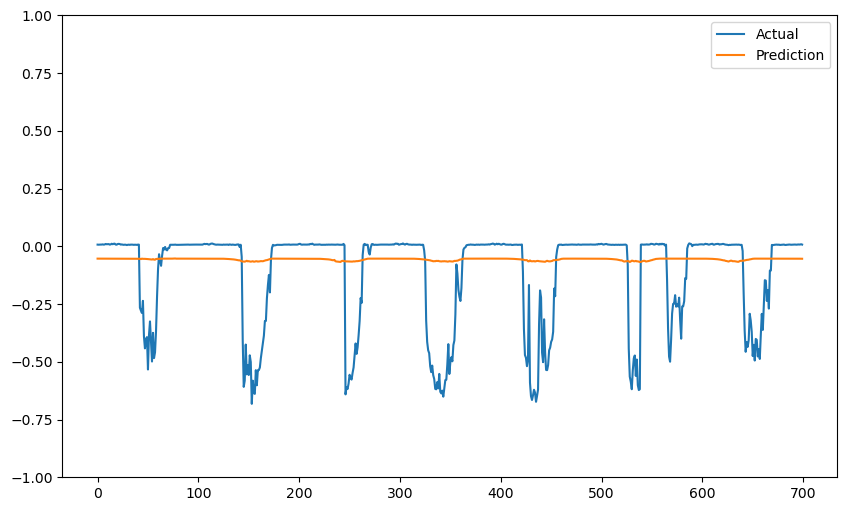

In [88]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Actuals'][0:700], label='Actual')
plt.plot(train_results['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MAE: {mean_absolute_error(y_train, train_predictions)}")

## Validation Results

In [89]:
val_predictions = gru_model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

3/3 [==============================] - 0s 27ms/step


,Val Predictions,Actuals
0,-0.053581,0.010679
1,-0.053607,0.011557
2,-0.053500,0.011854
3,-0.053498,0.010541
4,-0.053496,0.007156
...,...,...
91,-0.055767,0.007452
92,-0.055140,0.009159
93,-0.053878,0.007284
94,-0.053003,0.007570


Validation MAE: 0.10396853201296576


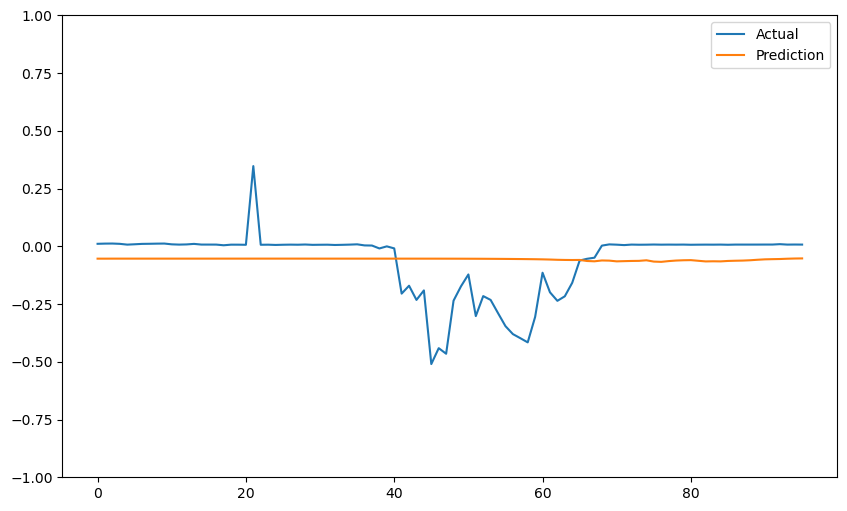

In [90]:
plt.figure(figsize=(10,6))
plt.plot(val_results['Actuals'], label='Actual')
plt.plot(val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Validation MAE: {mean_absolute_error(y_val, val_predictions)}")

## Test Results

In [91]:
test_predictions = gru_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

3/3 [==============================] - 0s 26ms/step


,Test Predictions,Actuals
0,-0.053492,0.006613
1,-0.053526,0.007452
2,-0.053515,0.007254
3,-0.053512,0.008152
4,-0.053516,0.007679
...,...,...
91,-0.053621,0.007274
92,-0.053583,0.009485
93,-0.053681,0.009811
94,-0.053398,0.007304


Test MAE: 0.1491510293930526


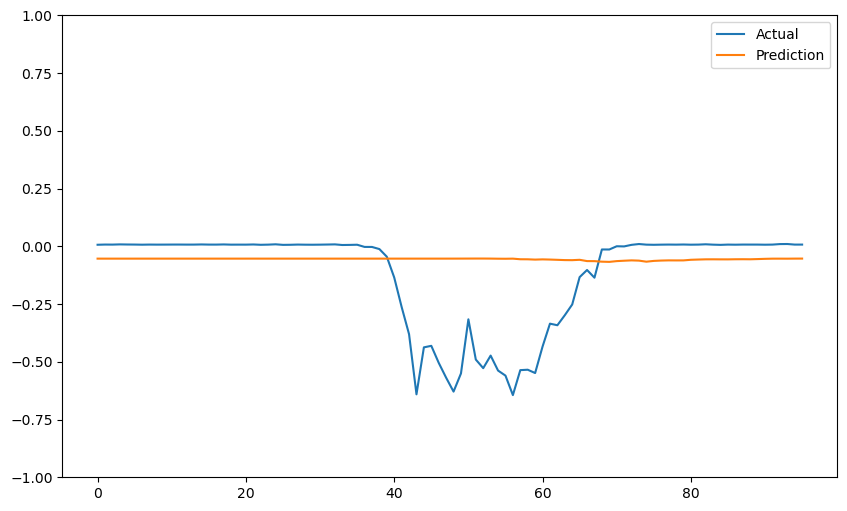

In [93]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Actuals'], label='Actual')
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Test MAE: {mean_absolute_error(y_test, test_predictions)}")

## <center> <u> Improving the Model 2

In [98]:
from keras.layers import Dropout

gru_model2 = keras.Sequential()
gru_model2.add(GRU(64, input_shape=(num_lags, 1), return_sequences=True))
gru_model2.add(Dropout(0.2))  # Adding dropout for regularization
gru_model2.add(GRU(64))
gru_model2.add(layers.BatchNormalization())
gru_model2.add(layers.Dense(1))

2024-03-26 20:50:29.028341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:50:29.029044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:50:29.029503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [101]:
#Do loss function of MSE instead of MAE, 2 Epochs
gru_model2.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])
gru_model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2)

Epoch 1/2


2024-03-26 20:52:35.188791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:52:35.189464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:52:35.190377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.0228

2024-03-26 20:58:05.840011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 20:58:05.840931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 20:58:05.841631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 331s 283ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 2/2
1163/1163 [==============================] - 329s 283ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0232 - val_mean_squared_error: 0.0232


## Training Results

In [102]:
train_predictions2 = gru_model2.predict(X_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train})
train_results2

2024-03-26 21:04:27.421226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 21:04:27.422003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 21:04:27.422676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 69s 59ms/step


,Train Predictions,Actuals
0,-0.001886,0.007195
1,-0.001875,0.006850
2,-0.001802,0.007195
3,-0.001750,0.007383
4,-0.001888,0.007402
...,...,...
37185,-0.026946,0.007402
37186,-0.019324,0.007738
37187,-0.008446,0.007284
37188,-0.002437,0.007422


Training MAE: 0.0697164938426485


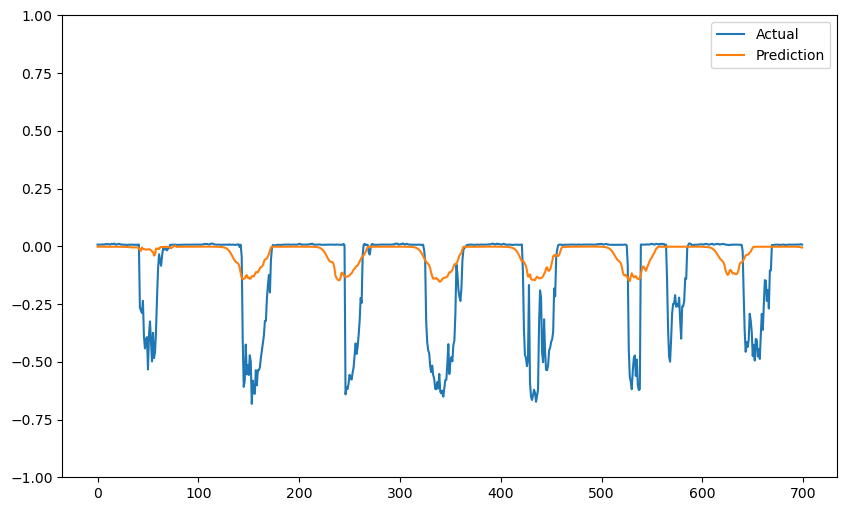

In [103]:
plt.figure(figsize=(10,6))
plt.plot(train_results2['Actuals'][0:700], label='Actual')
plt.plot(train_results2['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MAE: {mean_absolute_error(y_train, train_predictions2)}")

## Validation Results

In [104]:
val_predictions2 = gru_model2.predict(X_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val})
val_results2

3/3 [==============================] - 0s 69ms/step


,Val Predictions,Actuals
0,-0.002735,0.010679
1,-0.002768,0.011557
2,-0.002018,0.011854
3,-0.001990,0.010541
4,-0.001943,0.007156
...,...,...
91,-0.024853,0.007452
92,-0.018625,0.009159
93,-0.006469,0.007284
94,0.002342,0.007570


Validation MAE: 0.09517824754039195


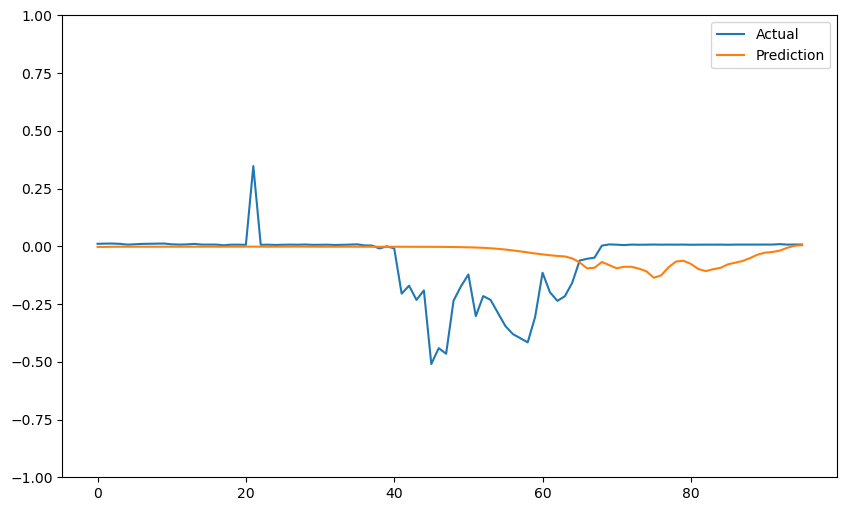

In [105]:
plt.figure(figsize=(10,6))
plt.plot(val_results2['Actuals'], label='Actual')
plt.plot(val_results2['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Validation MAE: {mean_absolute_error(y_val, val_predictions2)}")

## Testing Results

In [106]:
test_predictions2 = gru_model2.predict(X_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test})
test_results2

3/3 [==============================] - 0s 67ms/step


,Test Predictions,Actuals
0,-0.001893,0.006613
1,-0.002118,0.007452
2,-0.002047,0.007254
3,-0.002053,0.008152
4,-0.002070,0.007679
...,...,...
91,-0.002440,0.007274
92,-0.002986,0.009485
93,-0.003443,0.009811
94,-0.001565,0.007304


Test MAE: 0.1321764553415623


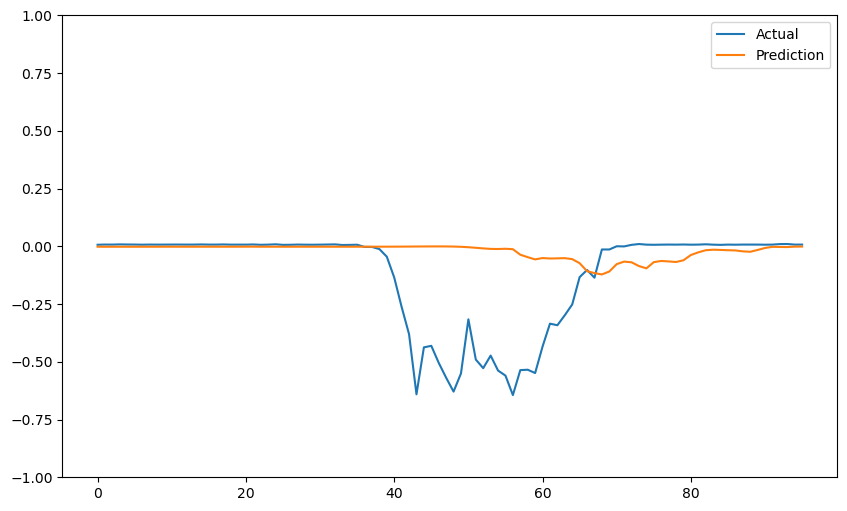

In [107]:
plt.figure(figsize=(10,6))
plt.plot(test_results2['Actuals'], label='Actual')
plt.plot(test_results2['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Test MAE: {mean_absolute_error(y_test, test_predictions2)}")

## <center> <u> Improving the Model 3

In [109]:
#Increase number of neurons to 128 for first GRU layer
gru_model3 = keras.Sequential()
gru_model3.add(GRU(128, input_shape=(num_lags, 1), return_sequences=True))
gru_model3.add(Dropout(0.3))
gru_model3.add(GRU(64))
gru_model3.add(layers.BatchNormalization())
gru_model3.add(layers.Dense(1))

2024-03-26 21:14:17.787826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 21:14:17.788691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 21:14:17.789336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
#Decrease learning rate to 0.001 to increase speed
gru_model3.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanSquaredError()])
gru_model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

## <center> <u> Improving the Model 4

In [116]:
gru_model4 = keras.Sequential()
gru_model4.add(GRU(64, input_shape=(num_lags, 1), return_sequences=True))
gru_model4.add(Dropout(0.2))  # Adding dropout for regularization
gru_model4.add(GRU(64))
gru_model4.add(layers.BatchNormalization())
gru_model4.add(Dense(8, 'relu'))
gru_model4.add(layers.Dense(1))

2024-03-27 09:55:43.888219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-27 09:55:43.889801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-27 09:55:43.890333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [117]:
#Decrease learning rate to 0.001 to increase speed
gru_model4.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanSquaredError()])
gru_model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5


2024-03-27 09:56:05.173818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-27 09:56:05.174864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-27 09:56:05.175494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.0212

2024-03-27 10:01:42.614947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-27 10:01:42.616003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-27 10:01:42.616754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 338s 289ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 2/5
1163/1163 [==============================] - 329s 283ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 3/5
1163/1163 [==============================] - 324s 279ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 4/5
1163/1163 [==============================] - 328s 282ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.1238 - val_mean_squared_error: 0.1238
Epoch 5/5
1163/1163 [==============================] - 326s 280ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0520 - val_mean_squared_error: 0.0520


In [118]:
train_predictions4 = gru_model4.predict(X_train).flatten()
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train})
train_results4

2024-03-27 10:27:06.351138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-27 10:27:06.352319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-27 10:27:06.352986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1163/1163 [==============================] - 68s 58ms/step


,Train Predictions,Actuals
0,-0.235472,0.007195
1,-0.235775,0.006850
2,-0.236124,0.007195
3,-0.235996,0.007383
4,-0.235954,0.007402
...,...,...
37185,-0.221581,0.007402
37186,-0.221940,0.007738
37187,-0.221572,0.007284
37188,-0.221819,0.007422


Training MAE: 0.2163918850703058


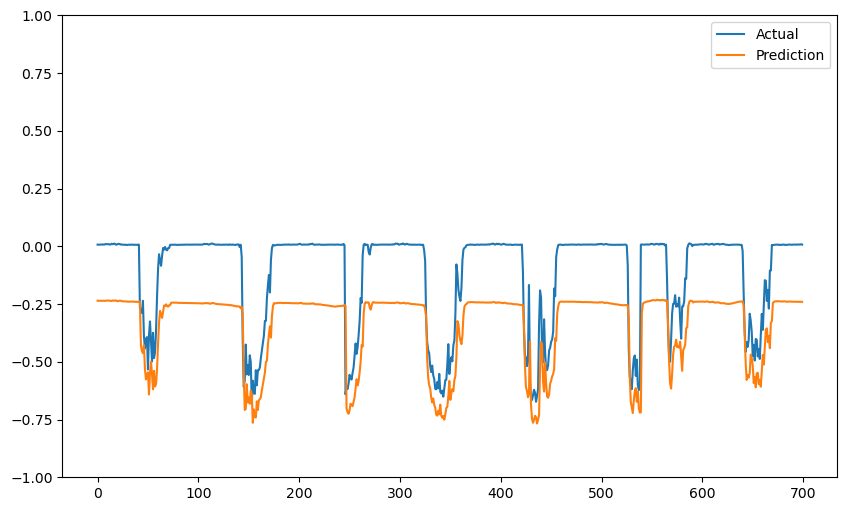

In [119]:
plt.figure(figsize=(10,6))
plt.plot(train_results4['Actuals'][0:700], label='Actual')
plt.plot(train_results4['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MAE: {mean_absolute_error(y_train, train_predictions4)}")

In [120]:
test_predictions4 = gru_model4.predict(X_test).flatten()
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test})
test_results4

3/3 [==============================] - 0s 67ms/step


,Test Predictions,Actuals
0,-0.218890,0.006613
1,-0.219431,0.007452
2,-0.218937,0.007254
3,-0.219063,0.008152
4,-0.218500,0.007679
...,...,...
91,-0.217779,0.007274
92,-0.217504,0.009485
93,-0.215979,0.009811
94,-0.215621,0.007304


Test MAE: 0.20107829443174538


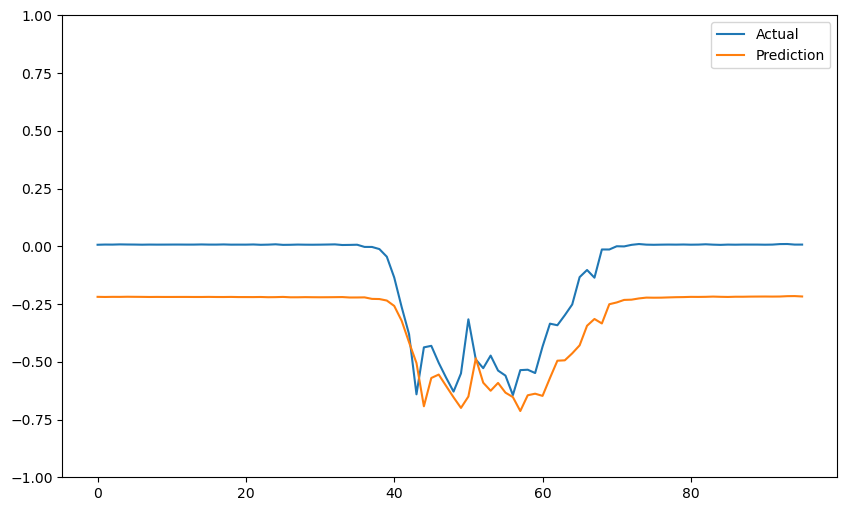

In [121]:
plt.figure(figsize=(10,6))
plt.plot(test_results4['Actuals'], label='Actual')
plt.plot(test_results4['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Test MAE: {mean_absolute_error(y_test, test_predictions4)}")

## <center> <u> Improving the Model 5

In [14]:
from keras.layers import GRU, Dropout, BatchNormalization

gru_model5 = keras.Sequential()
gru_model5.add(GRU(64, input_shape=(num_lags, 1), return_sequences=True))
gru_model5.add(Dropout(0.2))  # Adding dropout for regularization
gru_model5.add(GRU(128))
gru_model5.add(layers.BatchNormalization())
gru_model5.add(Dense(8, 'relu'))
gru_model5.add(layers.Dense(1))

In [21]:
gru_model5.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanSquaredError()])
gru_model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5


2024-03-27 10:45:26.860569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 496s 406ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 2/5
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 463s 398ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 3/5
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 806s 693ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 4/5
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 447s 384ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.1325 - val_mean_squared_error: 0.1325
Epoch 5/5
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 455s 391ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.3785 - val_mean_squared_error: 0.3785


In [22]:
train_predictions5 = gru_model5.predict(X_train).flatten()
train_results5 = pd.DataFrame(data={'Train Predictions':train_predictions5, 'Actuals':y_train})
train_results5

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 239s 198ms/step


,Train Predictions,Actuals
0,-0.674133,-0.005034
1,-0.656803,0.004382
2,-0.650384,0.000474
3,-0.652360,0.006682
4,-0.651179,0.006810
...,...,...
37185,-0.654131,0.007205
37186,-0.653873,0.010659
37187,-0.647538,0.009199
37188,-0.649252,0.001105


Training MAE: 0.6445599272541912


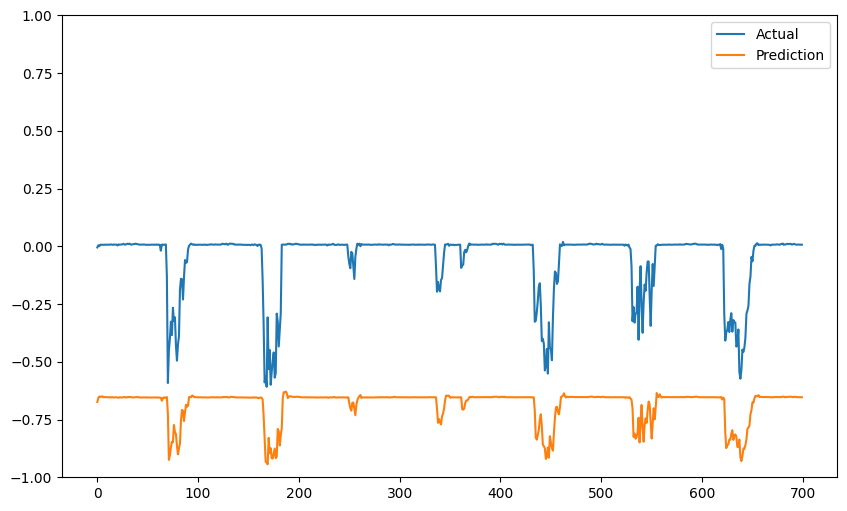

In [24]:
plt.figure(figsize=(10,6))
plt.plot(train_results5['Actuals'][0:700], label='Actual')
plt.plot(train_results5['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()
print(f"Training MAE: {mean_absolute_error(y_train, train_predictions5)}")